In [40]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
from nltk.tokenize import WhitespaceTokenizer
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.utils import simple_preprocess
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss, classification_report
import string
import re
import matplotlib.cm as cm 
from sklearn.pipeline import Pipeline

In [2]:
def load_text():
    train = pd.read_csv('data/evo_train_clean.csv.gz', compression='gzip', index_col='id')['NAME']
    test = pd.read_csv('data/evo_test_clean.csv.gz', compression='gzip', index_col='id')['NAME']
    return pd.concat([train, test])

In [3]:
def load_data():
    train = pd.read_csv('data/evo_train_clean.csv.gz', compression='gzip', index_col='id')
    categories = pd.read_csv('data/categories_parsed.csv.gz', compression='gzip', index_col='GROUP_ID')
    data = train.join(categories, on='GROUP_ID')
    return data

In [4]:
data = load_data()
texts = load_text()
data['NAME'] = data['NAME']
data.head()

,NAME,GROUP_ID,category,sub_category,low_category
id,,,,,
0,пиво жигулевский number литр св,35,Алкоголь,"Пиво, слабоалкогольные напитки",Прод
1,соус томатный буздяк number год татарский number,6,Прод,Продукты питания,Прод
2,сигарета esse ss exchange,7,Непрод,Табачные изделия,Непрод
3,петрушка,6,Прод,Продукты питания,Прод
4,пиво ягерь,35,Алкоголь,"Пиво, слабоалкогольные напитки",Прод


In [5]:
t = WhitespaceTokenizer()

def tokenize(series, tokenizer):
    return series.apply(lambda row: tokenizer.tokenize(row)).values

In [65]:
sentences = tokenize(texts, t)
w2v = Word2Vec(sentences=sentences, min_count=1, workers=4, size=3, seed=42)

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanEmbeddingVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = word2vec.vector_size

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [13]:
def prepare_data(data):
    X = data['NAME']
    y = data['low_category']
    return train_test_split(X, y, test_size=0.3, random_state=42)

X_train, X_test, y_train, y_test = prepare_data(data)

In [67]:
def plot_vectors(text, y, w2v):
    vectorizer = MeanEmbeddingVectorizer(w2v)
    vec = vectorizer.transform(text)
    
    colors = cm.rainbow(np.linspace(0, 1, len(set(y))))
    for y_, c in zip(set(y), colors):
        plt.scatter(vec[y.values==y_, 0], 
                    vec[y.values==y_, 1], c=c, alpha=0.5, label=str(y_))    

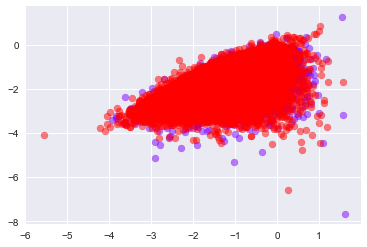

In [68]:
plot_vectors(data['NAME'], data['low_category'], w2v)

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

def show_metrics(y_true, y_pred, y_pred_proba):
    print("Accuracy: {}".format(accuracy_score(y_true, y_pred)))
    print("LogLoss: {}".format(log_loss(y_true, y_pred_proba)))
    print(classification_report(y_true, y_pred))
    cnf_matrix = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cnf_matrix, y_true.unique())

In [18]:
def pipeline(X_train, y_train, X_test, y_test, w2v):
    
    clf = Pipeline([
        ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
        ("log reg", LogisticRegression())
    ])
    
    clf.fit(X_train, y_train)
    
    pred = clf.predict(X_test)
    pred_proba = clf.predict_proba(X_test)
    
    show_metrics(y_test, pred, pred_proba)
    
    pred_df = pd.DataFrame(pred, index=X_test.index,columns=['predicted'])
    pred_df['real'] = y_test
    pred_df['NAME'] = data.ix[X_test.index, 'NAME']
    errors = pred_df[pred_df['real'] != pred_df['predicted']]
    
    return errors

Accuracy: 0.6898794605561522
LogLoss: 0.5768759105465214
             precision    recall  f1-score   support

     Непрод       0.71      0.91      0.80     11401
       Прод       0.53      0.23      0.32      5357

avg / total       0.66      0.69      0.65     16758

Confusion matrix, without normalization
[[10323  1078]
 [ 4119  1238]]


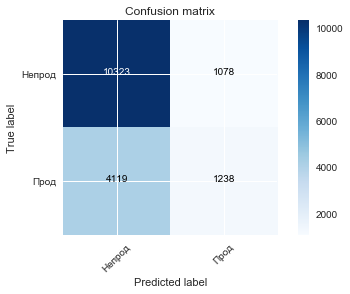

In [69]:
errors = pipeline(X_train, y_train, X_test, y_test, w2v)